In [1]:
# Import the dependencies
import os
import sys
import time
from collections import Counter
from dotenv import load_dotenv
from functools import reduce
from itertools import combinations
from joblib import Parallel, delayed
from pymongo import MongoClient
import pymongoarrow as pma
from pymongoarrow.api import write
import numba
from numba.typed import List
import numpy as np
from numpy.random import default_rng
import pandas as pd

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport

# Suppress YData profile report generation warnings - no actual problems to resolve.
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# Apply latest settings for Pandas
pd.options.mode.copy_on_write = True

### Load data from MongoDB

In [3]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get references to the data collections
data1 = db['ELR_Input_Data']
data2 = db['Encoded_Gov_Data']
data3 = db['Encoded_SSS_Data']

### Create DataFrames, Adjust columns, and set Index

In [4]:
# Create a dataframe from the ELR_Data collection
combined_df = pd.DataFrame(list(data1.find()))

# Create a dataframe from the Gov_Clusters collection
gc_df = pd.DataFrame(list(data2.find()))

# Create a dataframe from the SSS_Cluster collection
sc_df = pd.DataFrame(list(data3.find()))

In [5]:
# Create a copy of the original combined dataframe
ori_df = combined_df.copy()

# Drop the database id data and refresh the index
combined_df = combined_df.drop(['_id', 'Country', 'Year'], axis=1)
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.set_index('Country_Year')
combined_df = combined_df.drop(['Gov Type', 'SSS Type'], axis=1)
# Sort by index
combined_df = combined_df.sort_index()

gc_df = gc_df.drop(['_id'], axis=1)
gc_df = gc_df.reset_index(drop=True)
gc_df = gc_df.set_index('Country_Year')
# Sort by index
gc_df = gc_df.sort_index()

sc_df = sc_df.drop(['_id'], axis=1)
sc_df = sc_df.reset_index(drop=True)
# Sort by index
sc_df = sc_df.sort_index()

### Scale the numeric data before combining with binary encoded data

In [6]:
# Collect the column labels so they can be reapplied after data scaling
numeric_col_names = combined_df.columns.tolist()

# Standardize the data with MaxAbsScaler().
scaler = MaxAbsScaler()
scaled_nda = scaler.fit_transform(combined_df)

# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scaled_df = pd.DataFrame(scaled_nda, index=combined_df.index)

# Apply the column labels to ensure the data is properly identified
scaled_df = scaled_df.set_axis(numeric_col_names, axis=1)
scaled_df = scaled_df.sort_index()
scaled_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),Capital HE (% GDP),Domestic General Gov HE (% GDP),Domestic General Gov HE per capita (PPP Intl $),Domestic Private HE per capita (PPP Intl $),GDP growth per capita %,GDP per capita (PPP Intl $),Daily Caloric Supply,Tobacco use (% adults),Alcohol Use per capita (liters)
Country_Year,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.079641,0.015622,0.661004,0.510949,0.320488
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.196233,0.011698,0.662033,0.510949,0.320488
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.047142,0.011172,0.683140,0.510949,0.320488
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.072821,0.012607,0.719434,0.510949,0.320488
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.063851,0.014031,0.740541,0.510949,0.320488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,0.053123,0.118002,0.009254,0.011541,0.020710,0.015055,0.491120,0.176642,0.227805
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,0.469491,0.038642,0.002836,0.005581,-0.058210,0.014072,0.491120,0.176642,0.227805
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,0.036520,0.056014,0.003928,0.004664,-0.068838,0.012877,0.491120,0.170803,0.227805


### Assemble the complete dataset by merging the frames

In [7]:
# Merge the cluster DataFrames with the primary data.
frames = [scaled_df, gc_df, sc_df]
merge_frames_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

complete_df = merge_frames_df.copy().reset_index(drop=True)
complete_df = complete_df.set_index('Country_Year')
complete_df = complete_df.sort_index()
complete_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,...,0,0,0,0,0,0,0,0,0,0


### Assemble the complete visualization dataset by merging the unscaled numeric and binary encoded frames

In [8]:
# Prepare the visualization dataframe
frames = [combined_df, gc_df, sc_df]
merge_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [9]:
viz_df = merge_df.copy().reset_index(drop=True)
viz_df = viz_df.set_index('Country_Year')
viz_df = viz_df.sort_index()
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,2,1485.0,119.946788,3.286542,1.374478,73.144,13.71,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,2,1485.0,119.225912,3.266790,1.429833,73.378,14.52,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,2,1485.0,118.505073,3.247039,1.438342,73.715,15.93,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,2,1485.0,117.784197,3.227287,1.413557,73.939,13.68,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,1,657.0,38.909614,15.052184,5.770226,61.414,2.01,45.400288,4.670418,180.091128,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,1,657.0,39.691374,15.354608,5.912685,61.292,1.95,46.682095,3.659765,132.068691,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,1,657.0,40.505793,15.669666,6.008633,61.124,1.89,52.747667,3.425581,118.127063,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Define a function that generates a profile report and saves it to a file
def generate_report(df, config_file, output_file):
    profile = ProfileReport(df, config_file=config_file)
    profile.to_file(output_file)
    print(f"Report {output_file} generated.")

### Determine number of components for PCA ###

In [11]:
# Function to compute the viable PCA components for a given dataset
def compute_pca(input_data):  
    # Fit PCA on actual data
    pca_actual = PCA(svd_solver='full').fit(input_data)
    
    cumulative_variance_ratio = np.cumsum(pca_actual.explained_variance_ratio_)
    plt.plot(cumulative_variance_ratio)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.show()

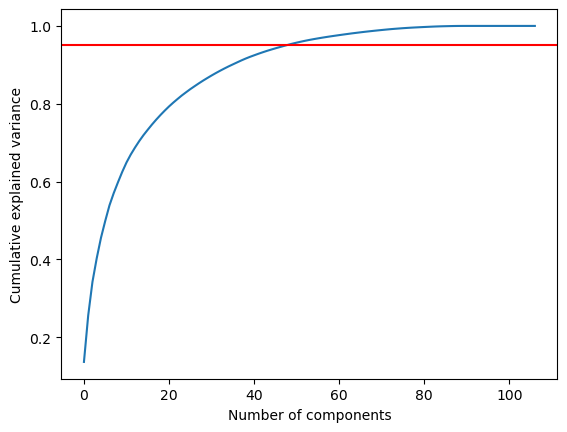

In [12]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(complete_df)

In [13]:
# Function to perform PCA for the provided data
def perform_pca(input_data, name, n_comp):
    pca = PCA(n_components=n_comp, random_state=42)
    pca_out = pca.fit_transform(input_data)

    # Create a DataFrame with the principal components.
    columnz =[]

    for i in range(1,n_comp+1):
        columnz.append(name + '_pc'+str(i))
    
    out_df = pd.DataFrame(data=pca_out, columns=columnz)

    out_df['Country_Year'] = ori_df['Country_Year']
    out_df = out_df.reset_index(drop=True)
    out_df = out_df.set_index('Country_Year')
    return out_df

#### Use the PCA data to guide component number selection

In [14]:
# Perform PCA on the complete_df.
complete_pca_df = perform_pca(complete_df, 'Complete', 45)

### Determine the number of (KMedoids) clusters for this complete dataset

In [15]:
# Use KMedoids and compute Davies-Bouldin scores, elbow curve, and silhouette scores to determine the optimal number of clusters.
def compute_kmedoids_cluster_metrics(data_in, n_clusters):
    """
    Function to compute cluster metrics for a given number of clusters.
    This function will be called in parallel.
    """
    # Initialize the clusterer with n_clusters value and random state for reproducibility
    clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    cluster_labels = clusterer.fit_predict(data_in)
    
    # Compute the scores for various metrics
    davies_bouldin = davies_bouldin_score(data_in, cluster_labels)
    inertia = clusterer.inertia_
    silhouette_avg = silhouette_score(data_in, cluster_labels)
    
    return n_clusters, davies_bouldin, inertia, silhouette_avg
    
def compute_clusters_parallel(data_in, max_clusters, n_jobs=-1):
    # Parallel computation of the cluster metrics for each number of clusters from 2 to max_clusters
    parallel = Parallel(n_jobs=n_jobs)
    kmedoids_cluster_metrics_list = parallel(delayed(compute_kmedoids_cluster_metrics)(data_in, n_clusters)
                                    for n_clusters in range(2, max_clusters + 1))

    # Creating a DataFrame to store the clustering metrics
    kmedoids_cluster_metrics_df = pd.DataFrame(kmedoids_cluster_metrics_list,
                                      columns=['Num_Clusters', 'Davies_Bouldin', 'Inertia', 'Silhouette_Avg'])

    return kmedoids_cluster_metrics_df

### Compute KMedoids clusters and metrics for the complete dataset

In [16]:
# Start timing
start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe
non_pca_kmedoid_cluster_scores_df = compute_clusters_parallel(data_in=complete_df, max_clusters=60, n_jobs=-1)

# Stop timing
stop = time.perf_counter()

print(f"KMedoids Clustering Execution in {stop - start:0.4f} seconds")

KMedoids Clustering Execution in 18.5323 seconds


### Compute KMedoids clusters and metrics for the PCA dataset

In [17]:
# Start timing
pca_kmedoid_cluster_start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe with PCA
pca_kmedoid_cluster_scores_df= compute_clusters_parallel(data_in=complete_pca_df, max_clusters=60, n_jobs=-1)

# Stop timing
pca_kmedoid_cluster_stop = time.perf_counter()

print(f"PCA KMedoids Clustering Execution in {pca_kmedoid_cluster_stop - pca_kmedoid_cluster_start:0.4f} seconds")

PCA KMedoids Clustering Execution in 15.4632 seconds


In [18]:
# Lower scores are better
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Davies_Bouldin')

:Scatter   [Num_Clusters]   (Davies_Bouldin)

In [19]:
# Higher scores are better
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Silhouette_Avg')

:Scatter   [Num_Clusters]   (Silhouette_Avg)

In [20]:
# define the model
cluster_model = KMedoids(n_clusters=55, init='k-medoids++', random_state=42)

# Fit the model and predict labels
cluster_model.fit_predict(complete_pca_df)

# Add the predicted class columns to the visualization dataset
complete_pca_viz_df = viz_df.copy()
complete_pca_viz_df['KMedoids Clusters'] = cluster_model.labels_

## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [21]:
# =============================================================================
# Custom processing function to override limitations of Numba compatibility with Numpy features
@numba.jit(nopython=True)
def custom_mean(arr, axis=0):
    if arr.ndim == 1:
        return arr.sum() / arr.shape[0]
    elif arr.ndim == 2:
        if axis == 0:
            return arr.sum(axis=0) / arr.shape[0]
        elif axis == 1:
            return arr.sum(axis=1) / arr.shape[1]
    raise ValueError("custom_mean function received an array that it can't handle with axis = {}")

In [22]:
# =============================================================================
# Function: Calinski Harbasz Score Calculation
def calculate_calinski_harbasz(np_array, labels):
    if len(np.unique(labels)) > 1:
        calinski_harbasz = calinski_harabasz_score(np_array, labels)
        return calinski_harbasz
    else:
        return 0

In [23]:
# =============================================================================
# Function: Davies-Bouldin Score Calculation
def calculate_davies_bouldin(np_array, labels):
    if len(np.unique(labels)) > 1:
        davies_bouldin = davies_bouldin_score(np_array, labels)
        return davies_bouldin
    else:
        return 0

In [24]:
# =============================================================================
# Function: Silhouette Coefficient Calculation
def calculate_silhouette(np_array, labels):
    if len(np.unique(labels)) > 1:
        silhouette_val = silhouette_score(np_array, labels)
        return silhouette_val
    else:
        return 0

In [25]:
# =============================================================================
# Function: Scatter Separability Calculation
def calculate_scatter_separability(np_array, labels):
    unique_labels = np.unique(labels)
    n_features = np_array.shape[1]
    overall_mean = custom_mean(np_array, axis=0)
    
    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for label in unique_labels:
        X_k = np_array[labels == label]
        mean_k = custom_mean(X_k, axis=0).reshape(n_features, 1)
        diff = X_k - mean_k.T
        S_w += np.dot(diff.T, diff)
        mean_diff = mean_k - overall_mean.reshape(n_features, 1)
        S_b += X_k.shape[0] * np.dot(mean_diff, mean_diff.T)

    # Check if S_w is invertible
    if np.linalg.cond(S_w) < 1/sys.float_info.epsilon:
        final_ssc = np.trace(np.linalg.inv(S_w).dot(S_b))
    else:
        final_ssc = 0

    return final_ssc

In [26]:
# =============================================================================
# Function: Normalization of criterion values to remove bias due to number of clusters - Numba acceleration
@numba.jit(nopython=True)
def cross_projection_normalization(clustering_medoids, scatter_criteria_score, silhouette_criteria_score, davies_bouldin_score, calinski_harbasz_index):
    n_clusters = len(clustering_medoids)
    projections = np.zeros((n_clusters, n_clusters))

    for j in range(n_clusters):
        for k in range(j + 1, n_clusters):
            medoid_j = clustering_medoids[j]
            medoid_k = clustering_medoids[k]
            distance = np.linalg.norm(medoid_j - medoid_k)
            projections[j][k] = distance
            projections[k][j] = distance

    # Flatten the array and filter non-zero distances then calculate the mean
    flat_projections = projections.ravel()
    non_zero_projections = flat_projections[flat_projections > 0]
    mean_projection = np.mean(non_zero_projections)

    # Normalizing the criteria scores with the mean of projections
    # Adjusting the formula to consider Davies-Bouldin Score. Recall: For Davies-Bouldin, lower is better.
    # We add 1 to the normalization_numerator and normalization_factor to ensure it doesn't lead to division by zero or negative values.

    # Combined normalization factor incorporates all metrics.
    normalization_factor = (1 + mean_projection + davies_bouldin_score) 
    normalization_numerator = (1 + scatter_criteria_score + silhouette_criteria_score + calinski_harbasz_index)
    normalized_score = normalization_numerator / normalization_factor

    return normalized_score

In [27]:
# =============================================================================
# Helper function for Sequential Forward Search
def evaluate_feature_subset(subset_array, np_array, cluster_labels, clustering_medoids):
    scatter_separability = calculate_scatter_separability(subset_array, cluster_labels)
    silhouette_score = calculate_silhouette(subset_array, cluster_labels)
    davies_bouldin_score = calculate_davies_bouldin(subset_array, cluster_labels)
    calinski_harbasz_index = calculate_calinski_harbasz(subset_array, cluster_labels)
    normalized_score = cross_projection_normalization(clustering_medoids, scatter_separability, silhouette_score, davies_bouldin_score, calinski_harbasz_index)

    return normalized_score

In [28]:
# =============================================================================
# Main Function - Function that orchestrates sequential forward search for important features and 
# evaluates different numbers of clusters to locate the optimal value
def optimal_feature_clusters(np_array, clustering_algorithm):
    rng = default_rng()  # Use numpy's Generator for random number generation.
    n_features = np_array.shape[1]
    available_indices = set(range(n_features))  # Initial set of available indices
    interim_features = set()
    starter_set = set()
    initial_k = np.array([2, 3, 4, 6, 7, 8, 9, 10, 11, 12])
    evaluate = True
    init_k = 2
    best_k = init_k
    best_score = 0
    best_combination_score = 0
    processed_features = 0
    starter_set_size = max(1, int(0.1 * n_features))

    print(f' Start processing with k = {init_k} and {len(available_indices)} available_indices... ')

    if clustering_algorithm == 'kmedoids':
        clustering_instance = KMedoids(n_clusters=init_k, init='k-medoids++', metric='manhattan', random_state=42)          
    elif clustering_algorithm == 'hdbscan':
        clustering_instance = HDBSCAN(min_cluster_size=10, min_samples=20, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
    else:
        raise ValueError("Unsupported clustering algorithm")

    best_feature = None
    best_score = 50
    
    while processed_features < int(0.9 * n_features):
        if len(interim_features) == 0 or interim_features is None:
            print(' interim_features is currently empty - creating starter_set from scratch ')
            starter_set = rng.choice(n_features, starter_set_size)
        else:
            print(' Interim_features exist - determining features available for use in starter_set ... ')
            remaining_indices = available_indices - interim_features
            
            if len(remaining_indices) < starter_set_size:
                print(' Almost at the end - using remaining features as the starter set... ')
                starter_set = rng.choice(list(remaining_indices), len(remaining_indices), replace=False)
            else:
                print(' Creating a starter set of fresh features ... ')
                starter_set = rng.choice(list(remaining_indices), starter_set_size, replace=False)

        for feature in range(n_features):
            if feature not in starter_set and feature not in interim_features:  # Check for both conditions
                combined_features = np.concatenate([starter_set, [feature]])
                subset_array = np.hstack([np_array[:, combined_features]])
                current_labels = clustering_instance.fit_predict(subset_array)
                if clustering_algorithm == 'kmedoids':
                    clustering_medoids = clustering_instance.cluster_centers_
                elif clustering_algorithm == 'hdbscan':
                    clustering_medoids = clustering_instance.medoids_
                # Score the feature                  
                normalized_score = evaluate_feature_subset(subset_array, np_array, current_labels, clustering_medoids)

                # Update best feature if necessary
                if normalized_score > best_score:
                    best_score = normalized_score
                    best_feature = feature
    
            # Ensure best_feature is not already in interim_features before appending
            if best_feature is not None and best_feature not in interim_features:
                interim_features.add(best_feature)
                print(f' Found a new interim feature - Best Score = {best_score:0.4f} - {len(interim_features)} found so far... ')
                available_indices.remove(best_feature)
                
        processed_features += len(starter_set)  # Account for multiple features in starter set
        print(f' Processed {processed_features} % of Features')
    best_combination_score = best_score
    subset_array = None
    starter_set = None
    print(f'^^^^^^^^^^^^^^^^^^^^^^^^^^{len(interim_features)} Initial features identified - continuing with combination evaluation ^^^^^^^^^^^^^^^^^')

    min_cluster_size = 30
    best_cluster_size = 0
    for init_k in initial_k:
        if clustering_algorithm == 'kmedoids':
            print(f'****** k-value set to {init_k} ***************************')
            clustering_instance = KMedoids(n_clusters=init_k, init='k-medoids++', metric='manhattan', random_state=42)
        elif clustering_algorithm == 'hdbscan':
            min_cluster_size += 10
            clustering_instance = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_cluster_size, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
            
        # Process combinations with the current selected features
        best_add = None
        
        for i in available_indices:
            # Create combination subset - evaluate new feature alongside the interim_features
            combination_array = np.hstack([np_array[:, [i]], np_array[:, list(interim_features)]])
            current_labels = clustering_instance.fit_predict(combination_array)
            if clustering_algorithm == 'kmedoids':
                clustering_medoids = clustering_instance.cluster_centers_
            elif clustering_algorithm == 'hdbscan':
                clustering_medoids = clustering_instance.medoids_
            # Score the combination            
            normalized_score = evaluate_feature_subset(combination_array, np_array, current_labels, clustering_medoids)
                
            # Update best combination if necessary
            if normalized_score > best_combination_score:
                best_combination_score = normalized_score
                print(f'  ++++++++ Best Combination Score Updated = {best_combination_score:0.4f} ++++++++')
                best_add = i
                best_k = init_k

        # If a better combination was found, add its feature to selected features
        if best_add is not None and best_add not in interim_features:
            interim_features.add(best_add)
            available_indices.remove(best_add)
            best_cluster_size = min_cluster_size
            print(f' number of interim features = {len(interim_features)} and number of available_indices = {len(available_indices)}... ')
        else:
            if clustering_algorithm == 'kmedoids':
                print('xxxxx  No further progress >>>> Moving to next K >>>>>>>')
            elif clustering_algorithm == 'hdbscan':
                min_cluster_size += 40
                print('xxxxx  No further progress >>>> Moving to next iteration >>>>>>>')
                #print('xxxxx  No further progress >>>> Ending Early ||||')
                #break
                
    print(f' Processing completed - Total number of identified features = {len(interim_features)}')

    return best_k, interim_features, best_cluster_size


### Perform PFA

#### KMedoids

In [29]:
# Add a k-value tracker for the output runs - use this to determine the appropriate value for final clustering
final_KM_k = []

In [30]:
# Start timing
start = time.perf_counter()

best_k = -99
best_kmedoid_features = set()

complete1_df = complete_df.copy()
complete1_np = complete1_df.to_numpy()
# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k, best_kmedoid_features, not_used = optimal_feature_clusters(complete1_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #1 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k = {best_k}')
print(f' best features = {best_kmedoid_features}')

final_KM_k.append(best_k)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 539.3308 - 1 found so far... 
 Found a new interim feature - Best Score = 860.6098 - 2 found so far... 
 Found a new interim feature - Best Score = 1445.1461 - 3 found so far... 
 Found a new interim feature - Best Score = 2815.9192 - 4 found so far... 
 Found a new interim feature - Best Score = 4147.8686 - 5 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 30 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Found a new i

In [31]:
# Start timing
start = time.perf_counter()

best_k2 = -99
best_kmedoid_features_2 = set()

complete2_df = complete_df.copy()
complete2_np = complete2_df.to_numpy()
# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k2, best_kmedoid_features_2, not_used = optimal_feature_clusters(complete2_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #2 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k = {best_k2}')
print(f' best features = {best_kmedoid_features_2}')

final_KM_k.append(best_k2)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 716.5452 - 1 found so far... 
 Found a new interim feature - Best Score = 1038.7334 - 2 found so far... 
 Found a new interim feature - Best Score = 1472.7397 - 3 found so far... 
 Found a new interim feature - Best Score = 1505.2246 - 4 found so far... 
 Found a new interim feature - Best Score = 1559.8668 - 5 found so far... 
 Found a new interim feature - Best Score = 1678.3705 - 6 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Found a new interim feature - Best Score = 2013.8403 - 7 found so far... 
 Processed 30 % of Feat

In [32]:
# Start timing
start = time.perf_counter()

best_k3 = -99
best_kmedoid_features_3 = set()

complete3_df = complete_df.copy()
complete3_np = complete3_df.to_numpy()
# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k3, best_kmedoid_features_3, not_used = optimal_feature_clusters(complete3_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #3 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k = {best_k3}')
print(f' best features = {best_kmedoid_features_3}')

final_KM_k.append(best_k3)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 533.2753 - 1 found so far... 
 Found a new interim feature - Best Score = 968.5956 - 2 found so far... 
 Found a new interim feature - Best Score = 1182.2247 - 3 found so far... 
 Found a new interim feature - Best Score = 2836.0247 - 4 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 30 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Found a new interim feature - Best Score = 3731.2554 - 5 found so far... 
 Found a new i

### Perform clustering with the reduced feature set

In [37]:
# Identify common k-value and features in the KMedoids output
# Count the frequency of each k value
k_counter = Counter(final_KM_k)

# Get all the most common values (in case of a tie)
most_common = k_counter.most_common()

# We want the smallest k in case of a tie
max_count = most_common[0][1]  # The count of the most common occurrence
ties = [k for k, count in most_common if count == max_count]

# Select the smallest k from the ties
selected_k = min(ties)

print(f"The selected k in case of a tie is: {selected_k}")

# Identify the common selected features
best_common_features = best_kmedoid_features & best_kmedoid_features_2 & best_kmedoid_features_3
final_kmedoid_common_features = sorted(list(best_common_features))

# Identify all the selected features
best_combined_features = best_kmedoid_features | best_kmedoid_features_2 | best_kmedoid_features_3
final_kmedoid_combined_features = sorted(list(best_combined_features))

The selected k in case of a tie is: 2


In [39]:
print(final_kmedoid_common_features)
print(final_kmedoid_combined_features)

[0, 2, 37, 83, 104]
[0, 1, 2, 3, 4, 7, 14, 21, 24, 35, 37, 53, 83, 84, 104]


In [41]:
# Use the selected features for the final KMedoids clustering

# Create a DataFrame for the best common features
kmedoids_common_df = complete_df.copy()
kmedoids_reduced_common_features_df = kmedoids_common_df.iloc[:,sorted(final_kmedoid_common_features)]

# Perform clustering on the final set of common features with the common k-value
kmedoids_final_common_model = KMedoids(n_clusters=selected_k, init='k-medoids++', metric='manhattan', random_state=42)
kmedoids_final_common_labels = kmedoids_final_common_model.fit_predict(kmedoids_reduced_common_features_df)
kmedoids_final_common_cluster_centers = kmedoids_final_common_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_viz_common_features_df = viz_df.copy()
kmedoids_final_reduced_common_features_df = kmedoids_final_viz_common_features_df.iloc[:,sorted(final_kmedoid_common_features)]
kmedoids_final_reduced_common_features_df['KMedoids Clusters'] = kmedoids_final_common_labels

kmedoids_final_COMMON_complete_features_df = viz_df.copy()
kmedoids_final_COMMON_complete_features_df['KMedoids Clusters'] = kmedoids_final_common_labels

# ------------------------------------------------------------------------------------------
# Create a DataFrame for the best combined features
kmedoids_combined_df = complete_df.copy()
kmedoids_reduced_combined_features_df = kmedoids_combined_df.iloc[:,sorted(final_kmedoid_combined_features)]

# Perform clustering on the final set of combined features with the common k-value
kmedoids_final_combined_model = KMedoids(n_clusters=selected_k, init='k-medoids++', metric='manhattan', random_state=42)
kmedoids_final_combined_labels = kmedoids_final_combined_model.fit_predict(kmedoids_reduced_combined_features_df)
kmedoids_final_combined_cluster_centers = kmedoids_final_combined_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_viz_combined_features_df = viz_df.copy()
kmedoids_final_reduced_combined_features_df = kmedoids_final_viz_combined_features_df.iloc[:,sorted(final_kmedoid_combined_features)]
kmedoids_final_reduced_combined_features_df['KMedoids Clusters'] = kmedoids_final_combined_labels

kmedoids_final_COMBINED_complete_features_df = viz_df.copy()
kmedoids_final_COMBINED_complete_features_df['KMedoids Clusters'] = kmedoids_final_combined_labels

In [43]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': kmedoids_final_reduced_common_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Common-Features_Report.html'
    },
    {
        'df': kmedoids_final_COMMON_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_COMMON_Complete-Features_Report.html'
    },
    {
        'df': kmedoids_final_reduced_combined_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Combined-Features_Report.html'
    },
    {
        'df': kmedoids_final_COMBINED_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_COMBINED_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f' ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ')

 ^^^ Final KMedoids Clustering Report building in 160.1135 seconds ^^^ 


#### HDBSCAN

In [47]:
# Add a cluster-size tracker for the output runs - use this to determine the appropriate value for final clustering
final_HDBSCAN_clusters = []

In [44]:
# Start timing
start = time.perf_counter()

complete4_df = complete_df.copy()
complete4_np = complete4_df.to_numpy()

best_hdbscan_features = set()
# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features, best_cluster_size = optimal_feature_clusters(complete4_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #1 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' best features 1 = {best_hdbscan_features}')

final_HDBSCAN_clusters.append(best_cluster_size)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 259.3788 - 1 found so far... 
 Found a new interim feature - Best Score = 821.5633 - 2 found so far... 
 Found a new interim feature - Best Score = 944.8047 - 3 found so far... 
 Found a new interim feature - Best Score = 1225.1389 - 4 found so far... 
 Found a new interim feature - Best Score = 1237.3588 - 5 found so far... 
 Found a new interim feature - Best Score = 1240.7112 - 6 found so far... 
 Found a new interim feature - Best Score = 1263.9234 - 7 found so far... 
 Found a new interim feature - Best Score = 1466.4817 - 8 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ..

In [45]:
# Start timing
start = time.perf_counter()

complete5_df = complete_df.copy()
complete5_np = complete5_df.to_numpy()

best_hdbscan_features_2 = set()
# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features_2, best_cluster_size2 = optimal_feature_clusters(complete5_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #2 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' best features 2 = {best_hdbscan_features_2}')

final_HDBSCAN_clusters.append(best_cluster_size2)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 59.0122 - 1 found so far... 
 Found a new interim feature - Best Score = 143.4360 - 2 found so far... 
 Found a new interim feature - Best Score = 238.6515 - 3 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Found a new interim feature - Best Score = 884.6929 - 4 found so far... 
 Found a new interim feature - Best Score = 1173.4382 - 5 found so far... 
 Found a new interim feature - Best Score = 1370.7675 - 6 found so far... 
 Processed 30 % of Features
 Interim_features exist - determining features available for use in starte

In [46]:
# Start timing
start = time.perf_counter()

complete6_df = complete_df.copy()
complete6_np = complete6_df.to_numpy()

best_hdbscan_features_3 = set()
# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features_3, best_cluster_size3 = optimal_feature_clusters(complete6_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #3 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' best features 3  = {best_hdbscan_features_3}')

final_HDBSCAN_clusters.append(best_cluster_size3)

 Start processing with k = 2 and 107 available_indices... 
 interim_features is currently empty - creating starter_set from scratch 
 Found a new interim feature - Best Score = 29076358.6657 - 1 found so far... 
 Found a new interim feature - Best Score = 76919752.5918 - 2 found so far... 
 Found a new interim feature - Best Score = 84730369.9986 - 3 found so far... 
 Found a new interim feature - Best Score = 95098812.2886 - 4 found so far... 
 Found a new interim feature - Best Score = 98493569.8954 - 5 found so far... 
 Found a new interim feature - Best Score = 116134982.6623 - 6 found so far... 
 Processed 10 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 20 % of Features
 Interim_features exist - determining features available for use in starter_set ... 
 Creating a starter set of fresh features ... 
 Processed 30 % of Features
 Interim_features exist - determining featur

### Perform clustering with the reduced feature set

In [53]:
final_HDBSCAN_clusters.append(best_cluster_size)
final_HDBSCAN_clusters.append(best_cluster_size2)
final_HDBSCAN_clusters.append(best_cluster_size3)
print(best_cluster_size)
print(best_cluster_size2)
print(best_cluster_size3)

200
0
190


In [54]:
# Identify common cluster_size value and features in the HDBSCAN output
# Count the frequency of each cluster_size
cluster_size_counter = Counter(final_HDBSCAN_clusters)

# Get all the most common values (in case of a tie)
most_common_clusters = cluster_size_counter.most_common()

# We want the smallest cluster_size in case of a tie
max_count = most_common_clusters[0][1]  # The count of the most common occurrence
cluster_ties = [c_s for c_s, count in most_common_clusters if count == max_count]

# Select the largest cluster_size from the ties
selected_cluster_size = max(cluster_ties)

print(f"The selected cluster_size in case of a tie is: {selected_cluster_size}")

# Identify common features 
best_common_hdbscan_features = best_hdbscan_features & best_hdbscan_features_2 & best_hdbscan_features_3
final_hdbscan_common_features = list(best_common_hdbscan_features)

# Identify all selected features
best_combined_hdbscan_features = best_hdbscan_features | best_hdbscan_features_2 | best_hdbscan_features_3
final_hdbscan_combined_features = sorted(list(best_combined_hdbscan_features))

The selected cluster_size in case of a tie is: 200


In [55]:
print(final_hdbscan_common_features)
print(final_kmedoid_combined_features)

[0, 1]
[0, 1, 2, 3, 4, 7, 14, 21, 24, 35, 37, 53, 83, 84, 104]


In [56]:
# Create a DataFrame for the best common features
hdbscan_common_df = complete_df.copy()
hdbscan_reduced_common_features_df = hdbscan_common_df.iloc[:,sorted(final_hdbscan_common_features)]

# Perform clustering on the final set of common features with the common cluster_size
min_cluster_size = selected_cluster_size
hdbscan_final_common_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_cluster_size, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
hdbscan_final_common_labels = hdbscan_final_common_model.fit_predict(kmedoids_reduced_common_features_df)
hdbscan_final_common_cluster_centers = hdbscan_final_common_model.medoids_

# Create the dataframes for visualization
hdbscan_final_viz_common_features_df = viz_df.copy()
hdbscan_final_reduced_common_features_df = kmedoids_final_viz_common_features_df.iloc[:,sorted(final_hdbscan_common_features)]
hdbscan_final_reduced_common_features_df['HDBSCAN Clusters'] = hdbscan_final_common_labels

hdbscan_final_COMMON_complete_features_df = viz_df.copy()
hdbscan_final_COMMON_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_common_labels

# ------------------------------------------------------------------------------------------
# Create a DataFrame for the best combined features
hdbscan_combined_df = complete_df.copy()
hdbscan_reduced_combined_features_df = hdbscan_combined_df.iloc[:,sorted(final_hdbscan_combined_features)]

# Perform clustering on the final set of combined features with the common cluster_size
hdbscan_final_combined_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_cluster_size, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
hdbscan_final_combined_labels = hdbscan_final_combined_model.fit_predict(hdbscan_reduced_combined_features_df)
hdbscan_final_combined_cluster_centers = hdbscan_final_combined_model.medoids_

# Create the dataframes for visualization
hdbscan_final_viz_combined_features_df = viz_df.copy()
hdbscan_final_reduced_combined_features_df = hdbscan_final_viz_combined_features_df.iloc[:,sorted(final_hdbscan_combined_features)]
hdbscan_final_reduced_combined_features_df['HDBSCAN Clusters'] = hdbscan_final_combined_labels

hdbscan_final_COMBINED_complete_features_df = viz_df.copy()
hdbscan_final_COMBINED_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_combined_labels

### Generate reports to explore the clustering results (reduced feature set & complete feature set)

In [57]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': hdbscan_final_reduced_common_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Common-Features_Report.html'
    },
    {
        'df': hdbscan_final_COMMON_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_COMMON_Complete-Features_Report.html'
    },
    {
        'df': hdbscan_final_reduced_combined_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Combined-Features_Report.html'
    },
    {
        'df': hdbscan_final_COMBINED_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_COMBINED_Complete-Features_Report.html'
    }
]
# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

 ^^^ Final HDBSCAN Clustering Report building in 165.4733 seconds ^^^ 


### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
#gov_data = db['Encoded_Gov_Data']

In [ ]:
# prefered method - use PyMongoArrow - write the dataframes to the database
write(db.Cluster_Unscaled_Complete, viz_df)
write(db.Cluster_Scaled_Complete, complete_df)
write(db.Cluster_PCA_Complete, complete_pca_df)
write(db.Cluster_KMedoids_Reduced_Features, kmedoids_final_reduced_features_df)
write(db.Cluster_KMedoids_Complete_Features, kmedoids_final_complete_features_df)
write(db.Cluster_HDBSCAN_Reduced_Features, hdbscan_final_reduced_features_df)
write(db.Cluster_HDBSCAN_Complete_Features, hdbscan_final_complete_features_df)

In [ ]:
#kmedoids_cluster_centers_df = pd.DataFrame(kmedoids_final_cluster_centers)
#write(db.Cluster_KMedoids_Centers, kmedoids_cluster_centers_df)

# Create the dataframe
#kmedoids_labels_df = pd.DataFrame(kmedoids_final_labels)
#write(db.Cluster_KMedoids_Labels, kmedoids_labels_df)

# Create the dataframe
#hdbscan_centers_df = pd.DataFrame(hdbscan_final_cluster_centers)
#write(db.Cluster_HDBSCAN_Centers, hdbscan_centers_df)

# Create the dataframe
#hdbscan_labels_df = pd.DataFrame(hdbscan_final_labels)
#write(db.Cluster_HDBSCAN_Labels, hdbscan_labels_df)





In [ ]:
kmedoids_best_features_df = pd.DataFrame()
kmedoids_best_features_df['Features'] = best_kmedoid_features
kmedoids_best_features_df

In [ ]:
hbdbscan_best_features_df = pd.DataFrame()
hbdbscan_best_features_df['Features'] = best_hdbscan_features
hbdbscan_best_features_df